# Satellite Model and Orientation
Remove this after completing thus after completing the pattern below
## Packages

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import cv2
import os
import wandb
import pathlib
import callbacks
import numpy as np
import seaborn as sn
import tensorflow as tf
from itertools import product
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from callbacks import WandbBatchHistory
from sklearn.metrics import classification_report, confusion_matrix

### Verify GPU Connection

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Constants

In [4]:
image_dir = '../Synthetic Data Generator/processed/Dataset/training'
IMAGE_DIR = pathlib.Path(image_dir)
CLASS_NAMES = list(filter(lambda x: x != '.DS_Store', os.listdir(image_dir)))
IMAGE_COUNT = len(list(IMAGE_DIR.glob('*/*.png')))


VALIDATION_RATIO=0.2
TRAIN_RATIO=0.8

VALIDATION_DS_SIZE=int(IMAGE_COUNT * VALIDATION_RATIO)
TRAIN_DS_SIZE=int(IMAGE_COUNT * TRAIN_RATIO)

BATCH_SIZE = 16
STEPS_PER_EPOCH = int(np.ceil(TRAIN_DS_SIZE/BATCH_SIZE))
VALIDATION_STEPS_PER_EPOCH = int(np.ceil(VALIDATION_DS_SIZE/BATCH_SIZE))
AUTOTUNE = tf.data.experimental.AUTOTUNE
CLASS_NAMES

['cloudsat', 'ACRIMSAT', 'agena', 'chandra', 'MGS', 'aqua', 'Deep']

## Dataset Generation Pattern
Go to the tf.data section and follow along: https://www.tensorflow.org/tutorials/load_data/images
Stop at the performance section. Let's train this only on the classes with full samples that I had mentioned in slack. 

In [5]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [6]:
def decode_img(img):
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    #####  IMAGE BLURRING GOES HERE #####
    # Apply the komlogrov filter to the #
    # img variable.                     #
    #####################################
    
    return img

In [7]:
def process_file(file_path):
    label = get_label(file_path)
    
    img = tf.io.read_file(file_path)
    img = decode_img(img)

    return img, label

In [8]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
    else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [9]:
ds_files = tf.data.Dataset.list_files(str(IMAGE_DIR/'*/*.png'))
labeled_ds = ds_files.map(process_file, num_parallel_calls=AUTOTUNE)

full_dataset = prepare_for_training(labeled_ds)

train_ds = full_dataset.take(TRAIN_DS_SIZE)
validation_ds = full_dataset.skip(TRAIN_DS_SIZE)

In [10]:
train_ds.prefetch(BATCH_SIZE)
validation_ds.prefetch(BATCH_SIZE)

<PrefetchDataset shapes: ((None, None, None, 3), (None, 7)), types: (tf.float32, tf.bool)>

In [11]:
# Generate a new training batch
tr_image_batch, tr_label_batch = next(iter(train_ds))

### Peek at the Dataset

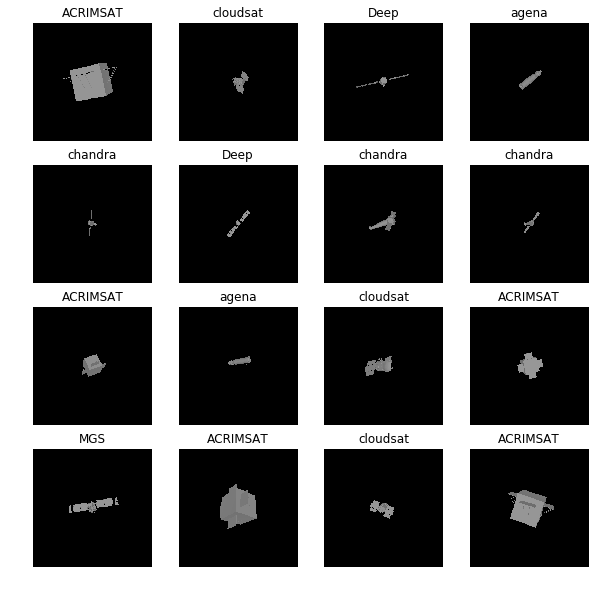

In [12]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        plt.title(tf.boolean_mask(CLASS_NAMES, label_batch[n])[0].numpy().decode())
        plt.axis('off')

show_batch(tr_image_batch.numpy(), tr_label_batch.numpy())

## Wandb Bayesian Search

Key is already saved in secret directory

In [13]:
wandb.login()

True

### Define the Sweep Config
Ryan will add all the sweep stuff here later. For now you can just throw whatever into here for the hyperparameters

In [29]:
sweep_config = {
    "name": "Artemis",
    "method": "grid",
    #"metric": {
    #    "name" : "val_loss",
    #    "goal" : "minimize"
    #},
    "parameters" : {
        "learning_rate" : {
            "values" : [1e-2, 1e-3, 1e-4]
        },
        "epochs" : {
            "values" : [5, 10, 15, 20]
        },
        "dropout_ly1" : {
            #"min"  : 3.0,
            #"max" : 7.0
            "values" : [0.4, 0.5, 0.6, 0.7]
        },
        "dropout_ly2" : {
            #"min"  : 3.0,
            #"max" : 7.0
            "values" : [0.4, 0.5, 0.6, 0.7]
        }, 
        "hidden_ly1" : {
            "values" : [256, 512, 1024]
        },
        "hidden_ly2" : {
            "values" : [256, 512, 1024]
        },
        "optimizer" : {
            "values" : ["adam", "rmsprop", "sgd"]
        },
        "activation" : {
            "values" : ["relu", "tanh", "sigmoid"]
        }
    }
}

## Initialize the Sweep ID

In [26]:
sweep_id = wandb.sweep(sweep_config, project="satellite-model-and-orientation")

Create sweep with ID: b95eyd9d
Sweep URL: https://app.wandb.ai/rosenblatt/satellite-model-and-orientation/sweeps/b95eyd9d


## TensorFlow ResNet
### Create the Model

In [16]:
def build_finetune_model(base_model, dropouts, fc_layers, activation, num_classes):

    x = base_model.output
    x = tf.keras.layers.Flatten()(x)

    for fc, drop in zip(fc_layers, dropouts):
        x = tf.keras.layers.Dense(fc, activation=activation)(x) 
        x = tf.keras.layers.Dropout(drop)(x)

    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [17]:
#We will ignore this for now
def build_fixed_model(base_model, dropouts, fc_layers, activation, num_classes):
    
    for layer in base_model.layers:
        layer.trainable = False

    return build_finetune_model(base_model, dropouts, fc_layers, activation, num_classes)

## Setup the Model Traning Function
Make sure to add the generator to the x value in the fit function

In [79]:
def train(config=None, group=None):
    # Set up your default hyperparameters before wandb.init
    # so they get properly set in the sweep

    """
    hyperparameter_defaults = dict(
        learning_rate = 1e-4,
        epochs = 10,
        dropout_ly1 = 0.5,
        dropout_ly2 = 0.5,
        hidden_ly1 = 1024,
        hidden_ly2 = 1024,
        optimizer = "adam",
        activation = "relu"
    )
    """
    
    hyperparameter_defaults = {
        "learning_rate" : 1e-4,
        "epochs" : 10,
        "dropout" : 0.5,
        "hidden" : 1024,
        "optimizer" : "adam",
        "activation" : "relu",
        "model" : "ResNet"
    }
    
    
    # Pass your defaults to wandb.init
    if config is None:
        config = hyperparameter_defaults
        
    wandb.init(config=config, group=group)
    
    
    # If sweeping, grab sweep configuration
    # config = wandb.config
    
    
    # will sweep models eventually
    if config['model'] == 'ResNet':
        model = tf.keras.applications.resnet.ResNet50(include_top=False, 
                                                      weights='imagenet', 
                                                      input_shape=(224,224,3), 
                                                      classes=len(CLASS_NAMES))
    elif config['model'] == 'VGG':
        model = tf.keras.applications.vgg16.VGG16(include_top=False, 
                                                      weights='imagenet', 
                                                      input_shape=(224,224,3), 
                                                      classes=len(CLASS_NAMES))

    # build the model
    """
    model = build_finetune_model(model, 
                                 [config['dropout_ly1'], config['dropout_ly2']], 
                                 [config['hidden_ly1'], config['hidden_ly2']],
                                  config['activation'], len(CLASS_NAMES))
    """
    
    model = build_finetune_model(model, 
                                 [config['dropout'], config['dropout']], 
                                 [config['hidden'], config['hidden']],
                                  config['activation'], len(CLASS_NAMES))
    
    # configure the early stop callback
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1)
    
    # setup the optimizer
    if config['optimizer'] == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    elif config['optimizer'] == "rmsprop":
        opt = tf.keras.optimizers.RMSprop(learning_rate=config['learning_rate'])
    elif config['optimizer'] == "sgd":
        opt = tf.keras.optimizers.SGD(learning_rate=config['learning_rate'])
    
    # compile the model
    model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

    # begin training callbacks.WandbBatchHistory()
    model.fit(train_ds, epochs=config['epochs'], callbacks=[earlystop, wandb.keras.WandbCallback()],
              steps_per_epoch=STEPS_PER_EPOCH, validation_data=validation_ds, validation_steps=VALIDATION_STEPS_PER_EPOCH)
    
    # batch_size=wandb.config['batch_size']

## Test the train function

In [ ]:
train()

## Sweep the Model

## Grid Search from Scratch

In [83]:
def gridSearch(config):

    keys, values = zip(*config.items())
    
    total = 1
    for v in values:
        total *= len(v)
    
    with tqdm(total=total) as pbar:
        for bundle in tqdm(product(*values)):
            pbar.update(1)
            d = dict(zip(keys, bundle))
            train(config=d, group="Grid Search")
    
    return 'Grid Search Complete'

In [86]:
my_config = {
        "learning_rate" : [1e-2, 1e-3, 1e-4],
        "epochs" : [10],
        "hidden" : [256, 512, 1024],
        "dropout" : [0.5],
        "optimizer" : ["adam", "sgd"],
        "activation" : ["relu", "tanh"],
        "model" : ["ResNet", "VGG"]
    }

In [ ]:
gridSearch(my_config)

Train for 350 steps, validate for 88 steps
Epoch 1/10
350/350 [==============================] - 241s 688ms/step - loss: 4.3148 - accuracy: 0.2252 - val_loss: 2.0019 - val_accuracy: 0.1470
Epoch 2/10
350/350 [==============================] - 230s 657ms/step - loss: 1.8664 - accuracy: 0.2509 - val_loss: 1.7413 - val_accuracy: 0.2777
Epoch 3/10
350/350 [==============================] - 230s 658ms/step - loss: 1.6997 - accuracy: 0.2904 - val_loss: 1.6296 - val_accuracy: 0.2862
Epoch 4/10
350/350 [==============================] - 225s 644ms/step - loss: 1.6641 - accuracy: 0.3082 - val_loss: 1.7697 - val_accuracy: 0.3338
Epoch 5/10
350/350 [==============================] - 225s 643ms/step - loss: 1.6326 - accuracy: 0.3057 - val_loss: 1.7611 - val_accuracy: 0.2791
Epoch 6/10
350/350 [==============================] - 227s 647ms/step - loss: 1.5192 - accuracy: 0.3380 - val_loss: 1.5260 - val_accuracy: 0.3537
Epoch 7/10
350/350 [==============================] - 219s 625ms/step - loss: 1.5

Train for 350 steps, validate for 88 steps
Epoch 1/10
349/350 [============================>.] - ETA: 0s - loss: 4.9929 - accuracy: 0.2423

## Demo the Final Model
NOTE: best_model_path needs to be assigned programatically, val_ds generator being used here

In [12]:
best_model_path = 'wandb/run-20200504_022746-tzla9y6v/model-best.h5'
best_model = tf.keras.models.load_model(best_model_path)

### Prediction Demo

In [13]:
def prediction_demo(model, image_batch, label_batch):
    
    predictions = model.predict(image_batch, verbose=1)

    plt.figure(figsize=(10,10))
    
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        plt.title('Truth: ' + tf.boolean_mask(CLASS_NAMES, label_batch[n])[0].numpy().decode() +
                  '\nPrediction: ' + CLASS_NAMES[np.argmax(predictions[n])] +
                  '\nConfidence: ' + str(round(np.max(predictions[n]*100),1)) + '%'
                 )

        plt.axis('off')

    plt.subplots_adjust(top=1.2, right = 1.0)

### Display Demo

In [14]:
demo_image_batch, demo_label_batch = next(iter(validation_ds))

16/16 [==============================] - 6s 381ms/sample


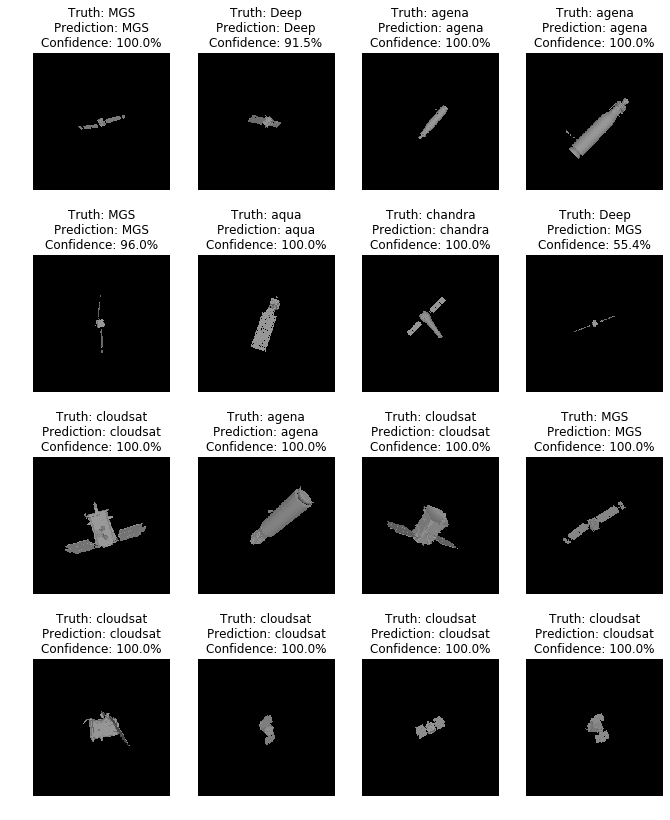

In [15]:
prediction_demo(best_model, demo_image_batch, demo_label_batch)

## Evaluate the Final Model
Add Confussion Matrix, Calculate F1-Score stuff and log all of it to wandb:
https://docs.wandb.com/library/log

## DO NOT RUN YET 

In [48]:
preds = best_model.predict(validation_ds, verbose=1, steps=VALIDATION_STEPS_PER_EPOCH)
validation_ds_np = validation_ds.as_numpy_iterator()

88/88 [==============================] - 100s 1s/step


In [57]:
predictions = np.argmax(preds, axis=1)

In [58]:
predictions.shape

(1408,)

In [ ]:
predictions[-1]

In [64]:
a = next(validation_ds_np)

In [67]:
a[0].shape, a[1].shape

((16, 224, 224, 3), (16, 7))

In [ ]:
from tqdm.notebook import tqdm, trange

val_truth = []
for elm in trange(VALIDATION_DS_SIZE):
    val_truth.append(next(validation_ds_np))

In [56]:
## probably doable in one loop or without loops
labels = [tf.boolean_mask(CLASS_NAMES, t)[0].numpy().decode() for t in val_truth]
y_val = [np.argmax(t) for t in val_truth]

confusion_mat = confusion_matrix(y_val, predictions)
classification_rep = classification_report(y_val, predictions, target_names=labels, output_dict=True)

KeyboardInterrupt: 